255
0
1.0
0.0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                        

Text(0.42, 0.98, 'Predicted label for the displayed shapes')

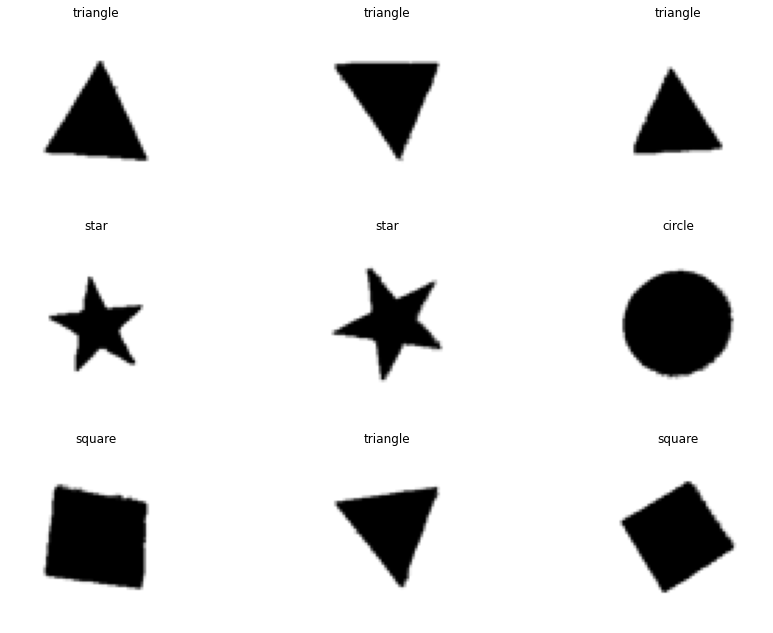

<Figure size 1440x1080 with 0 Axes>

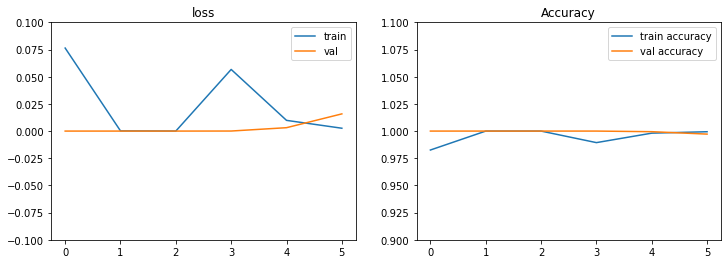

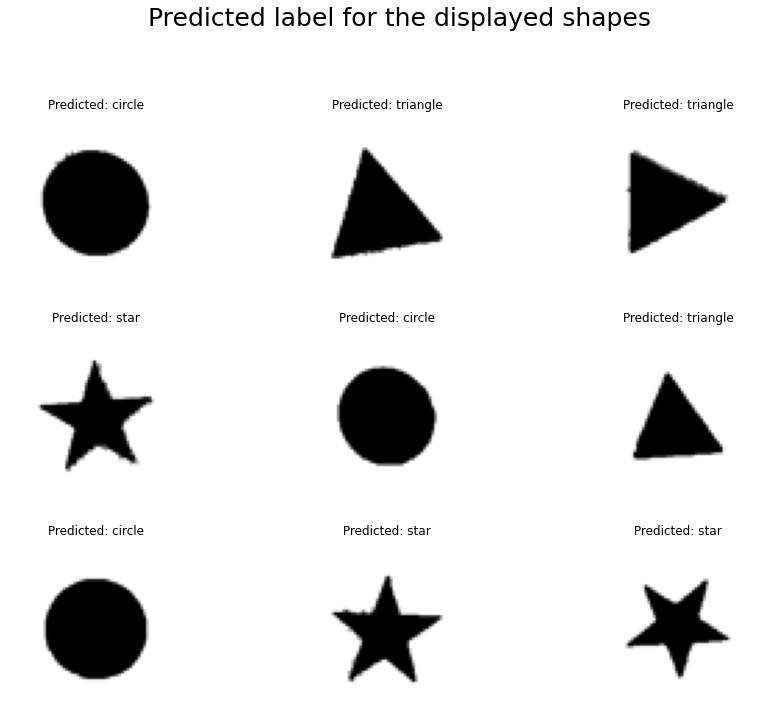

In [2]:
import numpy as np
import pandas as pd
import random
from PIL import Image
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from model import initialize_model, compile_model

categories = ["circle", "square", "star", "triangle"]

im_width = 64
im_height = 64

data = []
target = []

for cat in categories:
    filelist = glob.glob('./shapes/' + cat + '/*.png')
    target.extend([cat for _ in filelist])
    data.extend([np.array(Image.open(fname).resize((im_width, im_height))) for
                 fname in filelist])

data_array = np.stack(data, axis=0)
data_array.shape

plt.rc('image', cmap='gray')
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(4, 4)

for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off')
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image])

pd.DataFrame(target).value_counts()/len(target)

X_train, X_test, y_train, y_test = train_test_split(data_array,
                                                    np.array(target),
                                                    test_size=0.2,
                                                    stratify=target)

pd.DataFrame(y_train).value_counts()/len(y_train)
pd.DataFrame(y_test).value_counts()/len(y_test)

print(X_train.max())
print(X_train.min())

X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()

print(X_train_norm.max())
print(X_train_norm.min())

fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(4, 4)

if False:
    for line in range(0, 3):
        for row in range(0, 3):
            num_image = random.randint(0, X_train_norm.shape[0])
            ax = fig.add_subplot(gs[line, row])
            ax.axis('off')
            ax.set_title(y_train[num_image])
            ax.imshow(X_train_norm[num_image])

encoder = LabelEncoder().fit(y_train)
y_train_cat = encoder.transform(y_train)
y_test_cat = encoder.transform(y_test)

y_train_oh = to_categorical(y_train_cat)
y_test_oh = to_categorical(y_test_cat)

pd.DataFrame(y_test_oh).head()

X_train_norm = X_train_norm.reshape(-1, 64, 64, 1)
X_test_norm = X_test_norm.reshape(-1, 64, 64, 1)
X_train_norm.shape

model = initialize_model()
model.summary()

model = compile_model(model)
es = EarlyStopping(patience=5, monitor='val_accuracy',
                   restore_best_weights=True)

history = model.fit(X_train_norm, y_train_oh,
                    batch_size=8,
                    epochs=10,
                    validation_split=0.3,
                    callbacks=[es])


def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(-0.1, 0.1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy' + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy' + exp_name)
    ax2.set_ylim(0.9, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)


plot_history(history, title='', axs=None, exp_name="")


model.evaluate(X_test_norm, y_test_oh, verbose=0)

predictions = model.predict(X_test_norm)

fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(4, 4)

for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off')
        ax.set_title("Predicted: " + categories[list(np.round(
            predictions[num_image])).index(1)])
        ax.imshow(X_test_norm[num_image])
fig.suptitle("Predicted label for the displayed shapes", fontsize=25, x=0.42)
